In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import sklearn
import sklearn.preprocessing
import sklearn.model_selection
import os
import matplotlib.pyplot as plt
import math
import datetime

/home/wurst/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/wurst/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/wurst/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/wurst/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: Futu

In [2]:
csv_data = pd.read_csv('climate_clean.csv', index_col=0)

csv_data['Datum'] = pd.to_datetime(csv_data['Datum'])
csv_data.describe()

,Windgeschw Max,Windgeschw Mittel,Niederschlag,Niederschlagsform,Sonnenstunden,Schneehoehe,Bedeckungsgrad,Dampfdruck Mittel,Luftdruck Mittel,Lufttemp Mittel,Relative Feuchte,Lufttemp Max,Lufttemp Min,Lufttemp Min Erdboden
count,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000,41272.000000
mean,-0.563684,-0.852494,-0.955561,2.141064,-0.626977,-0.979950,0.339642,-0.800839,-0.008593,0.197568,0.545691,0.275287,0.127789,0.092258
std,0.197634,0.078658,0.090362,2.718331,0.349836,0.059778,0.569118,0.076497,0.008600,0.135471,0.233100,0.157096,0.122663,0.124756
min,-0.940000,-0.996000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-0.976000,-0.057200,-0.316000,-0.620000,-0.256000,-0.408000,-0.540000
25%,-0.712000,-0.916000,-1.000000,0.000000,-0.958333,-1.000000,0.000000,-0.862000,-0.013300,0.098000,0.400000,0.157500,0.040000,0.004000
50%,-0.596000,-0.868000,-0.998000,1.000000,-0.708333,-1.000000,0.450000,-0.810000,-0.007000,0.202000,0.560000,0.276000,0.134000,0.098000
75%,-0.444000,-0.788000,-0.950000,6.000000,-0.375000,-1.000000,0.825000,-0.746000,-0.003700,0.300000,0.720000,0.392000,0.222000,0.190000
max,0.668000,-0.432000,0.360000,8.000000,0.341667,-0.140000,1.000000,-0.480000,0.021000,0.592000,1.000000,0.744000,0.490000,0.436000


In [3]:
print(csv_data.loc[0])

Datum                    1891-01-01 00:00:00
Windgeschw Max                        -0.232
Windgeschw Mittel                     -0.844
Niederschlag                              -1
Niederschlagsform                          0
Sonnenstunden                           -0.9
Schneehoehe                            -0.92
Bedeckungsgrad                            -1
Dampfdruck Mittel                     -0.914
Luftdruck Mittel                      0.0028
Lufttemp Mittel                       -0.072
Relative Feuchte                        0.76
Lufttemp Max                            0.01
Lufttemp Min                          -0.118
Lufttemp Min Erdboden                  0.032
Name: 0, dtype: object


### Convert pandas DataFrame to np array

In [4]:
# 'Niederschlagsform' from categorical to one hot
nm_onehot_df = pd.get_dummies(csv_data['Niederschlagsform'])
nm_onehot_df.columns = ['Niederschlagsform_{}'.format(i) for i in [0, 1, 4, 6, 7, 8, 9]]

modified_data = pd.concat([csv_data, nm_onehot_df], axis=1).drop('Niederschlagsform', axis=1)

In [5]:
# 'Datum' to (day of the year) and (year)
modified_data['Datum_DOY'] = modified_data['Datum'].dt.dayofyear
modified_data['Jahr'] = modified_data['Datum'].dt.year
modified_data.drop('Datum', axis=1, inplace=True)

modified_data['Datum_DOY'] /= 183
modified_data['Datum_DOY'] -= 1

year_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
modified_data['Jahr'] = year_scaler.fit_transform(modified_data[['Jahr']])

/usr/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [6]:
modified_data

,Windgeschw Max,Windgeschw Mittel,Niederschlag,Sonnenstunden,Schneehoehe,Bedeckungsgrad,Dampfdruck Mittel,Luftdruck Mittel,Lufttemp Mittel,Relative Feuchte,...,Lufttemp Min Erdboden,Niederschlagsform_0,Niederschlagsform_1,Niederschlagsform_4,Niederschlagsform_6,Niederschlagsform_7,Niederschlagsform_8,Niederschlagsform_9,Datum_DOY,Jahr
0,-0.232,-0.844,-1.000,-0.900000,-0.92,-1.000,-0.914,0.00280,-0.072,0.7600,...,0.032,1,0,0,0,0,0,0,-0.994536,-1.0
1,-0.600,-0.876,-1.000,-0.950000,-0.96,-0.325,-0.918,-0.01620,-0.056,0.6800,...,-0.070,1,0,0,0,0,0,0,-0.989071,-1.0
2,-0.360,-0.928,-0.950,-1.000000,-0.86,-0.075,-0.922,-0.00990,-0.004,0.3800,...,-0.116,0,1,0,0,0,0,0,-0.983607,-1.0
3,-0.360,-0.948,-0.836,-0.883333,-0.88,1.000,-0.872,-0.00600,0.036,0.8000,...,-0.170,0,1,0,0,0,0,0,-0.978142,-1.0
4,-0.440,-0.820,-0.962,-0.933333,-0.90,0.925,-0.906,-0.01060,-0.050,0.7400,...,-0.072,0,1,0,0,0,0,0,-0.972678,-1.0
5,-0.328,-0.808,-0.950,-0.900000,-0.92,1.000,-0.930,-0.01440,-0.116,0.7600,...,0.012,0,1,0,0,0,0,0,-0.967213,-1.0
6,-0.680,-0.868,-0.942,-0.958333,-0.92,1.000,-0.928,-0.00840,-0.116,0.8800,...,0.072,0,1,0,0,0,0,0,-0.961749,-1.0
7,-0.720,-0.608,-1.000,-1.000000,-0.96,0.675,-0.926,0.00080,-0.100,0.7800,...,0.074,1,0,0,0,0,0,0,-0.956284,-1.0
8,-0.696,-0.672,-1.000,-1.000000,-0.90,0.675,-0.942,-0.00110,-0.156,0.7400,...,0.072,1,0,0,0,0,0,0,-0.950820,-1.0
9,-0.780,-0.728,-1.000,-0.958333,-0.90,-0.075,-0.958,-0.01450,-0.228,0.7000,...,0.006,1,0,0,0,0,0,0,-0.945355,-1.0


In [7]:
# Convert to np array
raw_np_data = modified_data.values

print(raw_np_data.shape)
raw_np_data[0]

(41272, 22)


array([-0.232     , -0.844     , -1.        , -0.9       , -0.92      ,
       -1.        , -0.914     ,  0.0028    , -0.072     ,  0.76      ,
        0.01      , -0.118     ,  0.032     ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.99453552, -1.        ])

In [8]:
print(modified_data.columns)

Index(['Windgeschw Max', 'Windgeschw Mittel', 'Niederschlag', 'Sonnenstunden',
       'Schneehoehe', 'Bedeckungsgrad', 'Dampfdruck Mittel',
       'Luftdruck Mittel', 'Lufttemp Mittel', 'Relative Feuchte',
       'Lufttemp Max', 'Lufttemp Min', 'Lufttemp Min Erdboden',
       'Niederschlagsform_0', 'Niederschlagsform_1', 'Niederschlagsform_4',
       'Niederschlagsform_6', 'Niederschlagsform_7', 'Niederschlagsform_8',
       'Niederschlagsform_9', 'Datum_DOY', 'Jahr'],
      dtype='object')


In [9]:
datetime_mapping = dict()
for x in raw_np_data:
    y = int(np.round(year_scaler.inverse_transform([[x[21]]])[0, 0]))
    d = int(np.round((x[20]+1) * 183))
    dt = datetime.datetime(y, 1, 1) + datetime.timedelta(d - 1)
    datetime_mapping[dt] = x
    
print(datetime_mapping[datetime.datetime(1891, 1, 1)])
print(len(datetime_mapping))

[-0.232      -0.844      -1.         -0.9        -0.92       -1.
 -0.914       0.0028     -0.072       0.76        0.01       -0.118
  0.032       1.          0.          0.          0.          0.
  0.          0.         -0.99453552 -1.        ]
41272


### Set up train/test split and batches

In [10]:
# Create a set of series for each possible starting point.
SERIES_LENGTH = 7 # number of days to consider
N_FEATURES = len(modified_data.columns)

n_series = len(raw_np_data) - SERIES_LENGTH - 1
all_series = np.ndarray((n_series, SERIES_LENGTH + 1, N_FEATURES))

for i in range(n_series):
    series = np.ndarray((SERIES_LENGTH + 1, N_FEATURES))
    for j in range(SERIES_LENGTH + 1):
        series[j, :] = raw_np_data[i+j, :]
    all_series[i, :, :] = series

print(all_series.shape)
print(all_series[0, 0, :])

(41264, 8, 22)
[-0.232      -0.844      -1.         -0.9        -0.92       -1.
 -0.914       0.0028     -0.072       0.76        0.01       -0.118
  0.032       1.          0.          0.          0.          0.
  0.          0.         -0.99453552 -1.        ]


In [11]:
X_all = all_series[:, :-1, :]
y_all = all_series[:, -1, :]

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_all, y_all, test_size=0.15)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(35074, 7, 22) (6190, 7, 22) (35074, 22) (6190, 22)


### Create simple model

In [12]:
model = keras.models.Sequential()

model.add(keras.layers.LSTM(128, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(keras.layers.LSTM(128, dropout=0.3, recurrent_dropout=0.3))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(N_FEATURES, activation='tanh'))

model.build((None, SERIES_LENGTH, N_FEATURES))

model.compile(
    optimizer='adam',
    loss='mae',
    metrics=['accuracy'])

model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 128)            77312     
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         


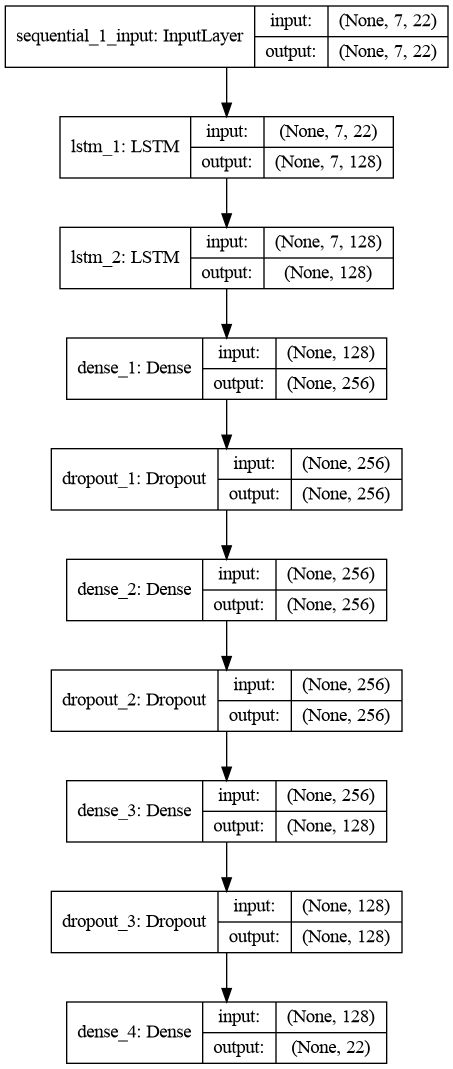

In [13]:
from IPython.display import Image
import pydot

keras.utils.plot_model(model, to_file=f'modelplot.png', show_shapes=True)

Image(f'modelplot.png')

In [15]:
hist = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=300,
    batch_size=256,
)

Train on 35074 samples, validate on 6190 samples
Epoch 1/300
35074/35074 [==============================] - 6s 172us/step - loss: 0.1356 - acc: 0.1318 - val_loss: 0.1188 - val_acc: 0.2087
Epoch 2/300
35074/35074 [==============================] - 6s 176us/step - loss: 0.1294 - acc: 0.1868 - val_loss: 0.1131 - val_acc: 0.2037
Epoch 3/300
35074/35074 [==============================] - 6s 172us/step - loss: 0.1242 - acc: 0.2264 - val_loss: 0.1095 - val_acc: 0.2725
Epoch 4/300
35074/35074 [==============================] - 6s 178us/step - loss: 0.1201 - acc: 0.3276 - val_loss: 0.1045 - val_acc: 0.4155
Epoch 5/300
35074/35074 [==============================] - 6s 176us/step - loss: 0.1167 - acc: 0.3833 - val_loss: 0.1014 - val_acc: 0.4929
Epoch 6/300
35074/35074 [==============================] - 6s 175us/step - loss: 0.1152 - acc: 0.4126 - val_loss: 0.0997 - val_acc: 0.5097
Epoch 7/300
35074/35074 [==============================] - 6s 175us/step - loss: 0.1134 - acc: 0.4317 - val_loss: 0.0

35074/35074 [==============================] - 6s 174us/step - loss: 0.1013 - acc: 0.5132 - val_loss: 0.0964 - val_acc: 0.5585
Epoch 60/300
35074/35074 [==============================] - 6s 177us/step - loss: 0.1012 - acc: 0.5166 - val_loss: 0.0954 - val_acc: 0.5598
Epoch 61/300
35074/35074 [==============================] - 6s 175us/step - loss: 0.1009 - acc: 0.5194 - val_loss: 0.0951 - val_acc: 0.5574
Epoch 62/300
35074/35074 [==============================] - 6s 176us/step - loss: 0.1014 - acc: 0.5146 - val_loss: 0.0950 - val_acc: 0.5517
Epoch 63/300
35074/35074 [==============================] - 6s 178us/step - loss: 0.1010 - acc: 0.5147 - val_loss: 0.0948 - val_acc: 0.5405
Epoch 64/300
35074/35074 [==============================] - 6s 173us/step - loss: 0.1007 - acc: 0.5178 - val_loss: 0.0969 - val_acc: 0.5556
Epoch 65/300
35074/35074 [==============================] - 6s 175us/step - loss: 0.1008 - acc: 0.5169 - val_loss: 0.0971 - val_acc: 0.5564
Epoch 66/300
35074/35074 [=======

35074/35074 [==============================] - 6s 176us/step - loss: 0.0992 - acc: 0.5204 - val_loss: 0.0970 - val_acc: 0.5607
Epoch 118/300
35074/35074 [==============================] - 6s 176us/step - loss: 0.0990 - acc: 0.5234 - val_loss: 0.0967 - val_acc: 0.5641
Epoch 119/300
35074/35074 [==============================] - 6s 177us/step - loss: 0.0992 - acc: 0.5189 - val_loss: 0.0972 - val_acc: 0.5591
Epoch 120/300
35074/35074 [==============================] - 6s 176us/step - loss: 0.0991 - acc: 0.5163 - val_loss: 0.0967 - val_acc: 0.5570
Epoch 121/300
35074/35074 [==============================] - 6s 179us/step - loss: 0.0990 - acc: 0.5185 - val_loss: 0.0976 - val_acc: 0.5570
Epoch 122/300
35074/35074 [==============================] - 6s 178us/step - loss: 0.0987 - acc: 0.5219 - val_loss: 0.0973 - val_acc: 0.5648
Epoch 123/300
35074/35074 [==============================] - 6s 176us/step - loss: 0.0989 - acc: 0.5203 - val_loss: 0.0975 - val_acc: 0.5596
Epoch 124/300
35074/35074 [

35074/35074 [==============================] - 6s 178us/step - loss: 0.0981 - acc: 0.5262 - val_loss: 0.0968 - val_acc: 0.5574
Epoch 176/300
35074/35074 [==============================] - 6s 173us/step - loss: 0.0988 - acc: 0.5144 - val_loss: 0.0986 - val_acc: 0.5512
Epoch 177/300
35074/35074 [==============================] - 6s 176us/step - loss: 0.0980 - acc: 0.5214 - val_loss: 0.0982 - val_acc: 0.5532
Epoch 178/300
35074/35074 [==============================] - 6s 178us/step - loss: 0.0983 - acc: 0.5265 - val_loss: 0.0963 - val_acc: 0.5575
Epoch 179/300
35074/35074 [==============================] - 6s 174us/step - loss: 0.0980 - acc: 0.5220 - val_loss: 0.0964 - val_acc: 0.5535
Epoch 180/300
35074/35074 [==============================] - 6s 178us/step - loss: 0.0979 - acc: 0.5189 - val_loss: 0.0976 - val_acc: 0.5564
Epoch 181/300
35074/35074 [==============================] - 6s 174us/step - loss: 0.0981 - acc: 0.5301 - val_loss: 0.0973 - val_acc: 0.5617
Epoch 182/300
35074/35074 [

35074/35074 [==============================] - 6s 175us/step - loss: 0.0972 - acc: 0.5336 - val_loss: 0.0973 - val_acc: 0.5669
Epoch 234/300
35074/35074 [==============================] - 6s 177us/step - loss: 0.0971 - acc: 0.5304 - val_loss: 0.0973 - val_acc: 0.5640
Epoch 235/300
35074/35074 [==============================] - 6s 174us/step - loss: 0.0970 - acc: 0.5287 - val_loss: 0.0971 - val_acc: 0.5519
Epoch 236/300
35074/35074 [==============================] - 6s 174us/step - loss: 0.0974 - acc: 0.5250 - val_loss: 0.0971 - val_acc: 0.5606
Epoch 237/300
35074/35074 [==============================] - 6s 178us/step - loss: 0.0971 - acc: 0.5273 - val_loss: 0.0966 - val_acc: 0.5502
Epoch 238/300
35074/35074 [==============================] - 6s 177us/step - loss: 0.0969 - acc: 0.5278 - val_loss: 0.0978 - val_acc: 0.5649
Epoch 239/300
35074/35074 [==============================] - 6s 175us/step - loss: 0.0968 - acc: 0.5337 - val_loss: 0.0974 - val_acc: 0.5635
Epoch 240/300
35074/35074 [

35074/35074 [==============================] - 6s 163us/step - loss: 0.0974 - acc: 0.5292 - val_loss: 0.0964 - val_acc: 0.5659
Epoch 292/300
35074/35074 [==============================] - 6s 165us/step - loss: 0.0967 - acc: 0.5273 - val_loss: 0.0968 - val_acc: 0.5619
Epoch 293/300
35074/35074 [==============================] - 6s 167us/step - loss: 0.0967 - acc: 0.5308 - val_loss: 0.0972 - val_acc: 0.5651
Epoch 294/300
35074/35074 [==============================] - 6s 162us/step - loss: 0.0967 - acc: 0.5317 - val_loss: 0.0990 - val_acc: 0.5641
Epoch 295/300
35074/35074 [==============================] - 6s 166us/step - loss: 0.0966 - acc: 0.5328 - val_loss: 0.0962 - val_acc: 0.5656
Epoch 296/300
35074/35074 [==============================] - 6s 167us/step - loss: 0.0964 - acc: 0.5298 - val_loss: 0.0976 - val_acc: 0.5611
Epoch 297/300
35074/35074 [==============================] - 6s 164us/step - loss: 0.0967 - acc: 0.5302 - val_loss: 0.0977 - val_acc: 0.5651
Epoch 298/300
35074/35074 [

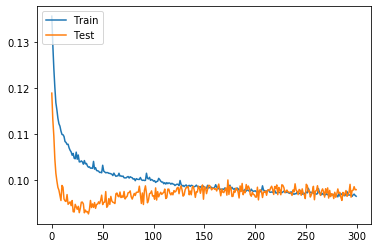

In [16]:
val_loss = hist.history['val_loss']
loss = hist.history['loss']

plt.plot(loss)
plt.plot(val_loss)
plt.legend(['Train', 'Test',], loc='upper left')

### "Decoding" of data

In [17]:
def decode_point(x):
    y_raw = dict(zip(modified_data.columns, x))
    y = dict()
    
    # "Niederschlagsform"
    y['Niederschlagsform'] = -1
    ndfs = [0, 1, 4, 6, 7, 8, 9]
    y['Niederschlagsform'] =  ndfs[np.argmax([y_raw['Niederschlagsform_{}'.format(i)] for i in ndfs])]
            
    # Date
    day = (y_raw['Datum_DOY'] + 1) * 183
    year = year_scaler.inverse_transform([[y_raw['Jahr']]])
    date = datetime.datetime(year, 1, 1) + datetime.timedelta(day - 1)
    y['Datum'] = date
    
    # scalar values
    scale_range = {
        'Windgeschw Max': (0, 50),
        'Windgeschw Mittel': (0, 50),
        'Niederschlag': (0, 100),
        'Sonnenstunden': (0, 24),
        'Schneehoehe': (0, 100),
        'Bedeckungsgrad': (0, 8),
        'Dampfdruck Mittel': (0, 100),
        'Luftdruck Mittel': (0, 2000),
        'Lufttemp Mittel': (-50, 50),
        'Relative Feuchte': (0, 100),
        'Lufttemp Max': (-50, 50),
        'Lufttemp Min': (-50, 50),
        'Lufttemp Min Erdboden': (-50, 50)
    }
    for key in scale_range:
        target_range = scale_range[key]
        y[key] = (y_raw[key] + 1) / 2 * (target_range[1] - target_range[0]) + target_range[0]
    
    return y
    
    
decode_point(X_train[0, 0, :])

{'Niederschlagsform': 7,
 'Datum': datetime.datetime(1979, 11, 4, 0, 0),
 'Windgeschw Max': 18.5,
 'Windgeschw Mittel': 6.2,
 'Niederschlag': 14.000000000000002,
 'Sonnenstunden': 0.09999999999999831,
 'Schneehoehe': 0.0,
 'Bedeckungsgrad': 7.7,
 'Dampfdruck Mittel': 10.499999999999998,
 'Luftdruck Mittel': 989.0,
 'Lufttemp Mittel': 11.100000000000001,
 'Relative Feuchte': 80.0,
 'Lufttemp Max': 11.799999999999997,
 'Lufttemp Min': 8.5,
 'Lufttemp Min Erdboden': 7.499999999999993}

In [25]:
test = X_train[101]
for i in range(SERIES_LENGTH):
    print(decode_point(test[i]))

{'Niederschlagsform': 7, 'Datum': datetime.datetime(1982, 10, 10, 0, 0), 'Windgeschw Max': 11.799999999999999, 'Windgeschw Mittel': 3.8000000000000007, 'Niederschlag': 3.4999999999999973, 'Sonnenstunden': 1.3000000000000007, 'Schneehoehe': 0.0, 'Bedeckungsgrad': 7.7, 'Dampfdruck Mittel': 10.700000000000005, 'Luftdruck Mittel': 987.1, 'Lufttemp Mittel': 10.399999999999999, 'Relative Feuchte': 84.0, 'Lufttemp Max': 13.600000000000001, 'Lufttemp Min': 9.199999999999996, 'Lufttemp Min Erdboden': 7.799999999999997}
{'Niederschlagsform': 7, 'Datum': datetime.datetime(1982, 10, 11, 0, 0), 'Windgeschw Max': 14.400000000000002, 'Windgeschw Mittel': 3.2, 'Niederschlag': 6.7, 'Sonnenstunden': 0.09999999999999831, 'Schneehoehe': 0.0, 'Bedeckungsgrad': 7.7, 'Dampfdruck Mittel': 11.6, 'Luftdruck Mittel': 981.2, 'Lufttemp Mittel': 10.799999999999997, 'Relative Feuchte': 90.0, 'Lufttemp Max': 12.100000000000001, 'Lufttemp Min': 9.699999999999996, 'Lufttemp Min Erdboden': 8.5}
{'Niederschlagsform': 7, 

In [26]:
test_pred = model.predict(test.reshape(1, SERIES_LENGTH, N_FEATURES)).reshape(-1)

print(decode_point(test_pred))
print('\n')
predicted_day = decode_point(test[-1])['Datum'] + datetime.timedelta(1)
print(decode_point(datetime_mapping[predicted_day]))

{'Niederschlagsform': 7, 'Datum': datetime.datetime(1982, 9, 22, 22, 39, 10, 391865), 'Windgeschw Max': 10.780832171440125, 'Windgeschw Mittel': 3.088049590587616, 'Niederschlag': 0.5354762077331543, 'Sonnenstunden': 2.186483860015869, 'Schneehoehe': 1.1920928955078125e-05, 'Bedeckungsgrad': 6.4085869789123535, 'Dampfdruck Mittel': 10.59773862361908, 'Luftdruck Mittel': 989.9677578359842, 'Lufttemp Mittel': 10.761507600545883, 'Relative Feuchte': 80.90938329696655, 'Lufttemp Max': 14.065995812416077, 'Lufttemp Min': 7.996883243322372, 'Lufttemp Min Erdboden': 6.651350110769272}


{'Niederschlagsform': 7, 'Datum': datetime.datetime(1982, 10, 17, 0, 0), 'Windgeschw Max': 15.4, 'Windgeschw Mittel': 5.199999999999999, 'Niederschlag': 0.10000000000000009, 'Sonnenstunden': 5.499999999999999, 'Schneehoehe': 0.0, 'Bedeckungsgrad': 3.7, 'Dampfdruck Mittel': 9.999999999999998, 'Luftdruck Mittel': 980.7, 'Lufttemp Mittel': 12.299999999999997, 'Relative Feuchte': 70.0, 'Lufttemp Max': 15.400000000

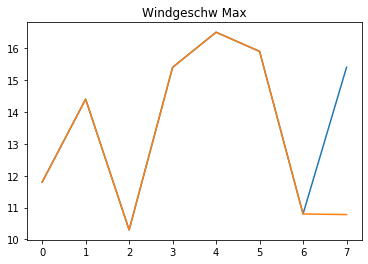

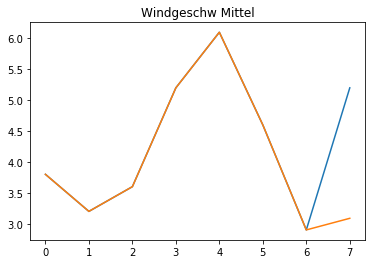

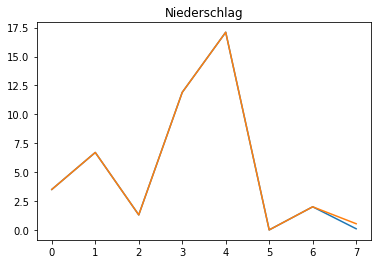

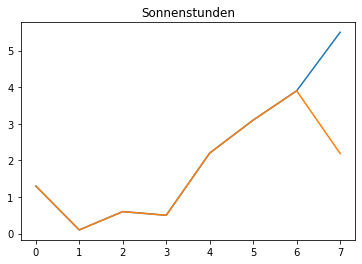

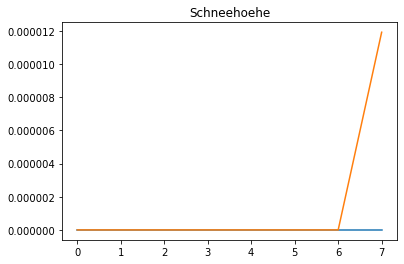

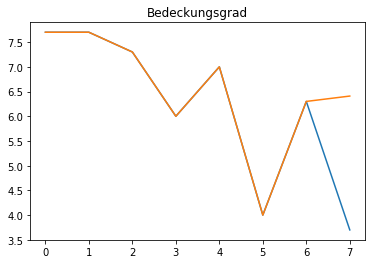

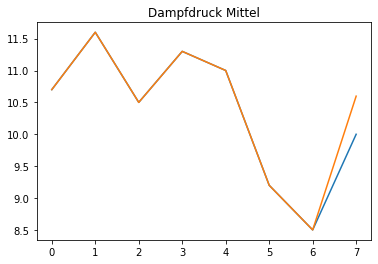

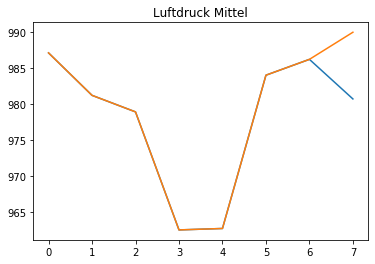

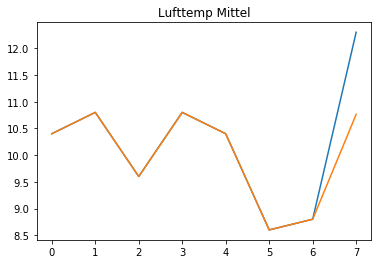

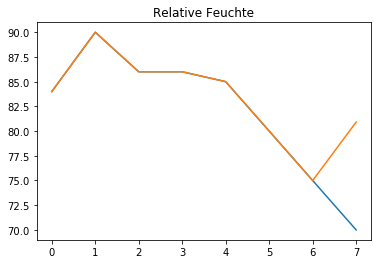

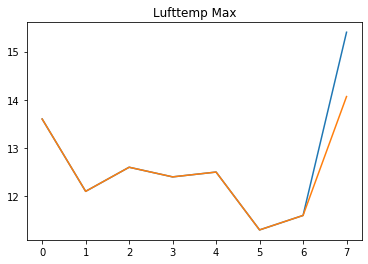

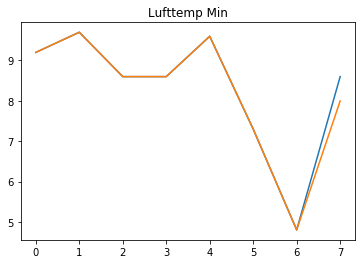

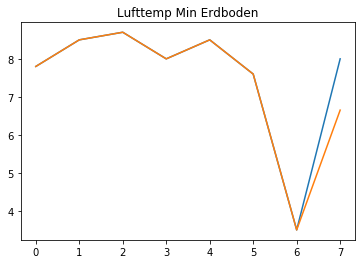

In [27]:
for k in [
    'Windgeschw Max', 'Windgeschw Mittel', 'Niederschlag', 'Sonnenstunden', 'Schneehoehe',
    'Bedeckungsgrad', 'Dampfdruck Mittel', 'Luftdruck Mittel', 'Lufttemp Mittel', 'Relative Feuchte',
    'Lufttemp Max', 'Lufttemp Min', 'Lufttemp Min Erdboden'
]:
    true = [decode_point(test[i])[k] for i in range(SERIES_LENGTH)]
    pred = true + [decode_point(test_pred)[k]]
    true += [decode_point(datetime_mapping[predicted_day])[k]]

    f = plt.figure()
    plt.plot(true)
    plt.plot(pred)
    plt.title(k)